In [ ]:
# Setting up the work for data-driven inference based on CitiBike data
# developed by Eve Marenghi for PUI in 2018

In [42]:
# Import the necessary packages
from __future__  import print_function, division
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import datetime as dt

%matplotlib inline

if os.getenv ('PUI2018') is None:
    print ("Must set env variable PUI2018")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2018")

Must set env variable PUI2018


## IDEA: 
## People in their 30s are less likely than people in their 20s to use CitiBike for commuting

## NULL HYPOTHESIS: 
## The proportion of people in their 20s biking on weekends is _the same or higher_ than the proportion of people in their 30s biking on weekends 

# $H_0$ : $\frac{30s_{\mathrm{weekend}}}{30s_{\mathrm{total}}} <= \frac{20s_{\mathrm{weekend}}}{20s_{\mathrm{total}}}$
# $H_1$ : $\frac{30s_{\mathrm{weekend}}}{30s_{\mathrm{total}}} > \frac{20s_{\mathrm{weekend}}}{20s_{\mathrm{total}}}$

or identically:

# $H_0$ : $\frac{30s_{\mathrm{weekend}}}{30s_{\mathrm{total}}} - \frac{20s_{\mathrm{weekend}}}{20s_{\mathrm{total}}} <= 0 $
# $H_1$ : $\frac{30s_{\mathrm{weekend}}}{30s_{\mathrm{total}}} - \frac{20s_{\mathrm{weekend}}}{20s_{\mathrm{total}}} > 0$

## I will use a significance level $\alpha=0.05$

### This means that I want the probability of getting a result to be at least as significant as mine to be less than 5%. 

## I am starting by reading data from CitiBike csv file from June 2015 

In [ ]:
!curl https://s3.amazonaws.com/tripdata/201506-citibike-tripdata.zip?accessType=DOWNLOAD > 201506-citibike-tripdata.zip

In [43]:
# Make sure an environmental variable for PUIdata exists
print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/em3932/PUIdata


In [38]:
!mv 201506-citibike-tripdata.zip $PUIDATA

In [44]:
# Test if the CitBike data is in PUIdata folder
!ls $PUIDATA

201506-citibike-tripdata.zip  water_consumption.csv


In [45]:
# Read the CitiBike data into a pandas dataframe (June 2015)
cb_df = pd.read_csv(os.getenv("PUIDATA") + '/201506-citibike-tripdata.zip')

# Convert starttime to a datetime object 
cb_df['date'] = cb_df['starttime'].apply(lambda x: dt.datetime.strptime(x, '%m/%d/%Y %H:%M'))

# Look at the top of the June dataframe
cb_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,1338,6/1/2015 0:00,6/1/2015 0:22,128,MacDougal St & Prince St,40.727103,-74.002971,2021,W 45 St & 8 Ave,40.759291,-73.988597,20721,Subscriber,1984.0,1,2015-06-01 00:00:00
1,290,6/1/2015 0:00,6/1/2015 0:05,438,St Marks Pl & 1 Ave,40.727791,-73.985649,312,Allen St & E Houston St,40.722055,-73.989111,21606,Subscriber,1997.0,1,2015-06-01 00:00:00
2,634,6/1/2015 0:01,6/1/2015 0:11,383,Greenwich Ave & Charles St,40.735238,-74.000271,388,W 26 St & 10 Ave,40.749718,-74.002950,16595,Subscriber,1993.0,1,2015-06-01 00:01:00
3,159,6/1/2015 0:01,6/1/2015 0:04,361,Allen St & Hester St,40.716059,-73.991908,531,Forsyth St & Broome St,40.718939,-73.992663,16949,Subscriber,1981.0,1,2015-06-01 00:01:00
4,1233,6/1/2015 0:02,6/1/2015 0:22,382,University Pl & E 14 St,40.734927,-73.992005,532,S 5 Pl & S 4 St,40.710451,-73.960876,17028,Customer,NaN,0,2015-06-01 00:02:00


In [46]:
# Get the column names
cb_df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'date'],
      dtype='object')

In [47]:
# Drop the columns we don't need
cb_df.drop(['tripduration', 'starttime','stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype', 'gender'], axis=1, inplace=True)

In [48]:
# Look at the top of the reduced dataframe
cb_df.head()

,birth year,date
0,1984.0,2015-06-01 00:00:00
1,1997.0,2015-06-01 00:00:00
2,1993.0,2015-06-01 00:01:00
3,1981.0,2015-06-01 00:01:00
4,NaN,2015-06-01 00:02:00


In [49]:
# Look at the bottom of the reduced dataframe
cb_df.tail()

,birth year,date
941214,1989.0,2015-06-30 23:59:00
941215,NaN,2015-06-30 23:59:00
941216,NaN,2015-06-30 23:59:00
941217,1976.0,2015-06-30 23:59:00
941218,1982.0,2015-06-30 23:59:00


In [50]:
# Find out how many rows are in the table
len(cb_df)

941219

In [51]:
# Remove NaN rows
cb_df = cb_df.dropna()

# Get the num rows again
len(cb_df)

810827

In [52]:
# Only keep ride for people in their 20s and 30s
cb_df = cb_df.drop(cb_df[(cb_df['birth year'] < 1979)].index)
cb_df = cb_df.drop(cb_df[(cb_df['birth year'] > 1998)].index)

In [53]:
# Find min and max birth years 
print(min(cb_df['birth year']))
print(max(cb_df['birth year']))

1979.0
1998.0


In [54]:
cb_df_30s = cb_df['date'][cb_df['birth year'] < 1989]
cb_df_20s = cb_df['date'][cb_df['birth year'] > 1988]

In [55]:
len(cb_df_30s)

301844

In [56]:
len(cb_df_20s)
# There are nearly 3x as many riders in their 30s as in their 20s

105810

In [61]:
type(cb_df['birth year'])

pandas.core.series.Series

In [64]:
# Add a 'decades' column to identify people in their 20s vs. 30s using mapping
birth_year_to_decade = {
  1979.0: '30s',
  1980.0: '30s',
  1981.0: '30s',
  1982.0: '30s',
  1983.0: '30s',
  1984.0: '30s',
  1985.0: '30s',
  1986.0: '30s',
  1987.0: '30s',
  1988.0: '30s',
    1989.0: '20s',
    1990.0: '20s',
    1991.0: '20s',
    1992.0: '20s',
    1993.0: '20s',
    1994.0: '20s',
    1995.0: '20s',
    1996.0: '20s',
    1997.0: '20s',
    1998.0: '20s',
}


In [67]:
# Add a 'decades' column to identify people in their 20s vs. 30s using mapping
cb_df['decade'] = cb_df['birth year'].map(birth_year_to_decade)
cb_df

,birth year,date,decade
0,1984.0,2015-06-01 00:00:00,30s
1,1997.0,2015-06-01 00:00:00,20s
2,1993.0,2015-06-01 00:01:00,20s
3,1981.0,2015-06-01 00:01:00,30s
11,1982.0,2015-06-01 00:08:00,30s
12,1985.0,2015-06-01 00:10:00,30s
13,1989.0,2015-06-01 00:11:00,20s
14,1983.0,2015-06-01 00:13:00,30s
16,1985.0,2015-06-01 00:13:00,30s
19,1984.0,2015-06-01 00:14:00,30s


## Separate people in their 20s and 30s to test the hypothesis

## Plot the number of trips per day of week

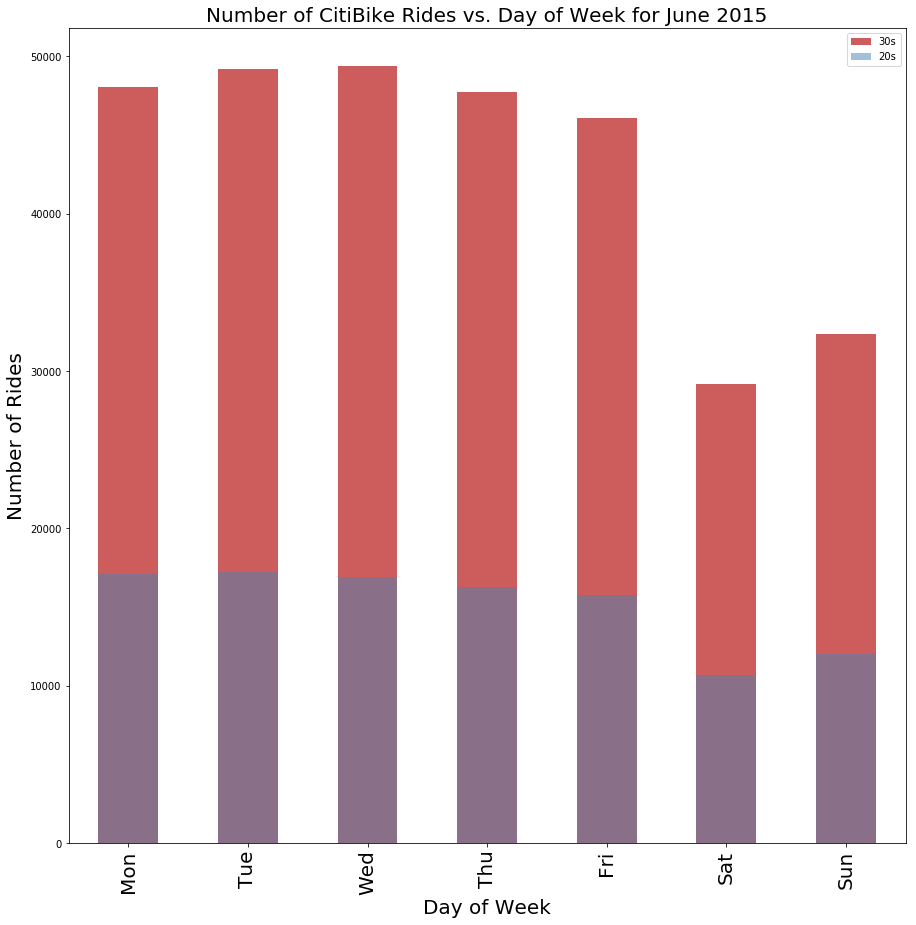

In [57]:
# Plot the number of trips per week day
fig = plt.figure(figsize = (15,15))

# Use the plot method in pandas
norm_w = 1
((cb_df['date'][cb_df['birth year'] < 1989].groupby([cb_df['date'].dt.weekday]).count()) / norm_w).plot(kind="bar", 
                                                                                         color='IndianRed', 
                                                                                         label='30s')

norm_m = 1
ax = ((cb_df['date'][cb_df['birth year'] > 1988].groupby([cb_df['date'].dt.weekday]).count()) / norm_m).plot(kind="bar", 
                                                                                              color='SteelBlue', 
                                                                                              alpha=0.5,
                                                                                              label='20s')

tmp = ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
ax.set_title ("Number of CitiBike Rides vs. Day of Week for June 2015", fontsize=20)
ax.set_ylabel ("Number of Rides", fontsize=20)
ax.set_xlabel ("Day of Week", fontsize=20)
plt.legend()

## Figure 1a: Distribution of CitiBike rider ages (20s or 30s) in June 2015, absolute counts. We can see from the chart that in total, there are more CitiBike riders in their 30s than in their 20s. We also see that there are lower total rides on Saturdays and Sundays compared to weekdays.

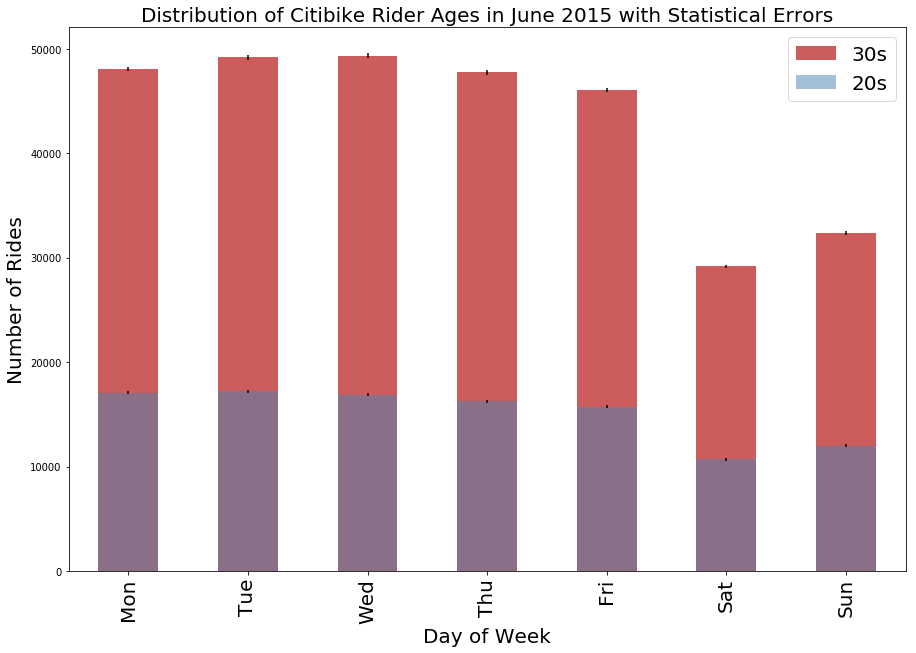

In [58]:
# Note: the counts have errors of course. what is the error on the count statistics?
# for N counts the error is sqrt(N) - this is because counts follow a Poisson statistic

fig = plt.figure(figsize = (15,10))

counts_w = cb_df.date[cb_df['birth year'] < 1989].groupby([cb_df.date.dt.weekday]).count()
norm_w = 1
error_w = np.sqrt(counts_w)
ax=((counts_w) / norm_w).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_w) / norm_w, (error_w) / norm_w)], label='30s')


counts_m = cb_df.date[cb_df['birth year'] > 1988].groupby([cb_df.date.dt.weekday]).count()
norm_m = 1
error_m=np.sqrt(counts_m)
((counts_m) / norm_m).plot(kind="bar", alpha=0.5, yerr=[((error_m) / norm_m, (error_m) / norm_m)], 
                           color='SteelBlue', label='20s')

ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=20)
ax.set_title ("Distribution of Citibike Rider Ages in June 2015 with Statistical Errors", fontsize=20)
ax.set_ylabel ("Number of Rides", fontsize=20)
ax.set_xlabel ("Day of Week", fontsize=20)
plt.legend(['30s','20s'],fontsize=20)

## Figure 1b: Distribution of Citibike rider ages (20s or 30s) in June 2015, absolute counts, with statistical errors

Note: These are absolute numbers. It is very hard to compare absolute numbers. Ratios (or proportions) are more ameable to comparison, so let's normalize the distribution of man, and that of women, i.e. devide them by the total number of rides for that gender. (Notice that we have to normalize the errorbars too!)

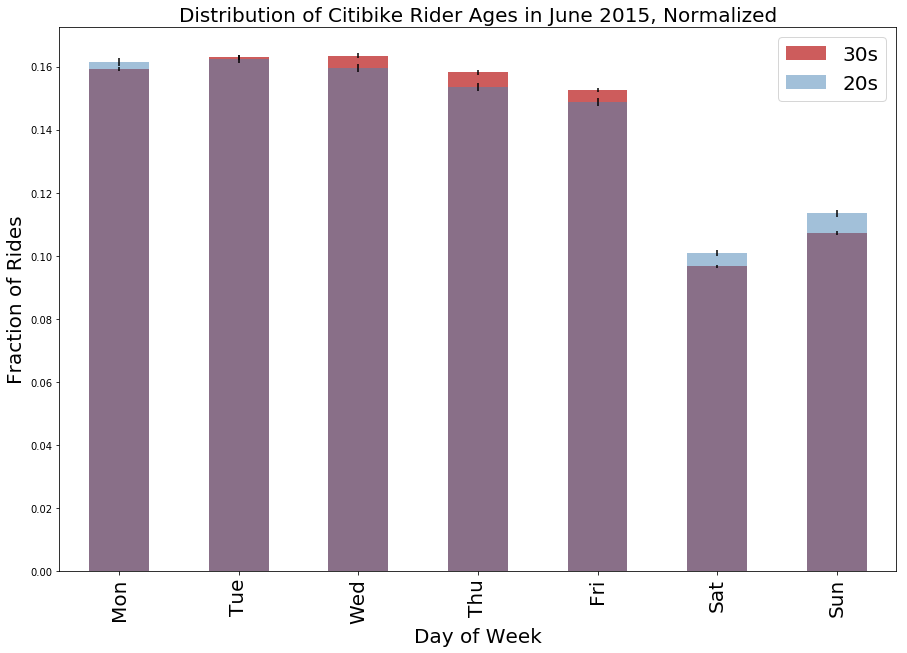

In [59]:
fig = plt.figure(figsize = (15,10))

norm_w = counts_w.sum()
error_w = np.sqrt(counts_w)
((counts_w) / norm_w).plot(kind="bar", color='IndianRed',  
                           yerr=[((error_w) / norm_w, (error_w) / norm_w)], 
                           label='30s')

norm_m = counts_m.sum()
ax = ((counts_m) / norm_m).plot(kind="bar", alpha=0.5, 
                                yerr=[((error_m) / norm_m, (error_m) / norm_m)], 
                                color='SteelBlue', label='20s')

ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
ax.set_title ("Distribution of Citibike Rider Ages in June 2015, Normalized", fontsize=20)
ax.set_ylabel ("Fraction of Rides", fontsize=20)
ax.set_xlabel ("Day of Week", fontsize=20)

plt.legend(['30s','20s'],fontsize=20)

## Figure 2: Distribution of CitiBike rider ages (20s or 30s) in June 2015, normalized